## 학습과정
### 1. Exploration
- policy는 큐함수에 대한 Bayesian Exploration으로 탐험

### 2. Sample 저장
- 에이전트는 Bayesian Exploration에 따라 [s, a, r, s']을 생성하고 reply mem에 append

### 3. random sampling으로 학습
- 미니배치 32
- 샘플로부터 target값과 prediction의 값을 구함
    - MSE : $(target - prediction)^2$
    - Target : $reward + \gamma \ max_{a'} q_{\theta} (s', a)$
    - Prediction : $q_{\theta}(s, a)$
- MSE error에 대한 gradient backpropagation설정

## Bayesian Exploration
### About Exploration : http://ishuca.tistory.com/399
drop_out을 설정

### 1. Import Libs

In [1]:
import os
import gym
import random
import numpy as np
from matplotlib import pyplot as plt
from collections import deque
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential

plt.style.use('ggplot')
np.random.seed(123)
EPISODES = 300

Using TensorFlow backend.


### 2. Define Agent & Model

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False # True
        
        # 상태와 행동 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        
        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.d_rate = 1.0 # dropout 비율
        self.d_rate_min = 0.0
        self.d_rate_end = 1
        self.d_rate_step = (self.d_rate - self.d_rate_min) / 5000
        self.batch_size = 64
        self.train_start = 1000
        
        # 리플라이 메모리. 최대 크기 2000
        self.memory = deque(maxlen=2000)
        
        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # 타깃 모델 초기화
        self.update_target_model()
        
        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn_bayesian_trained.h5")
            
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(rate=self.d_rate))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def get_action(self, state):
        q_value = self.model.predict(state)
        return np.argmax(q_value[0])
    
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def train_model(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
            
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)
        
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)
        
        ### Dropout설정
        for layer in self.model.layers:
            if isinstance(layer, Dropout):
                if self.d_rate > self.d_rate_min + self.d_rate_step:
                    self.d_rate -= self.d_rate_step
                else:
                    self.d_rate = self.d_rate_min
                layer.rate = self.d_rate

### 3. Training Model

[2018-05-08 15:17:56,198] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Den

episode: 68   score: 334.0   memory length: 2000   dropout rate: 0.0 global steps:  12518
episode: 69   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  13018
episode: 70   score: 212.0   memory length: 2000   dropout rate: 0.0 global steps:  13231
episode: 71   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  13731
episode: 72   score: 396.0   memory length: 2000   dropout rate: 0.0 global steps:  14128
episode: 73   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  14628
episode: 74   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  15128
episode: 75   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  15628
episode: 76   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  16128
episode: 77   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  16628
episode: 78   score: 342.0   memory length: 2000   dropout rate: 0.0 global steps:  16971
episode: 7

episode: 159   score: 395.0   memory length: 2000   dropout rate: 0.0 global steps:  42648
episode: 160   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  43148
episode: 161   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  43648
episode: 162   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  44148
episode: 163   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  44648
episode: 164   score: 210.0   memory length: 2000   dropout rate: 0.0 global steps:  44859
episode: 165   score: 272.0   memory length: 2000   dropout rate: 0.0 global steps:  45132
episode: 166   score: 356.0   memory length: 2000   dropout rate: 0.0 global steps:  45489
episode: 167   score: 463.0   memory length: 2000   dropout rate: 0.0 global steps:  45953
episode: 168   score: 317.0   memory length: 2000   dropout rate: 0.0 global steps:  46271
episode: 169   score: 364.0   memory length: 2000   dropout rate: 0.0 global steps:  46636

episode: 250   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  82846
episode: 251   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  83346
episode: 252   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  83846
episode: 253   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  84346
episode: 254   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  84846
episode: 255   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  85346
episode: 256   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  85846
episode: 257   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  86346
episode: 258   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  86846
episode: 259   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  87346
episode: 260   score: 500.0   memory length: 2000   dropout rate: 0.0 global steps:  87846

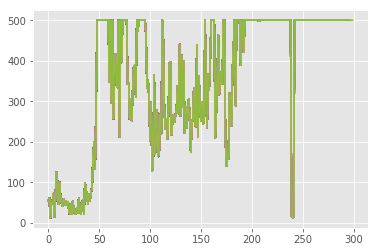

In [3]:
graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)
if not os.path.isdir(model_path):
    os.mkdir(model_path)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
scores, episodes = [], []
global_steps = 0

for episode in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    while True:
        if agent.render:
            env.render()
        
        ## 1. 스텝마다 샘플을 수집함
        ## 2. 스텝마다 모델을 학습
        ## 3. 에피소드마다 target모델을 업데이트
        
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        reward = reward if not done or score == 499 else -100
        
        agent.append_sample(state, action, reward, next_state, done)
        
        # 에피소드마다 학습하면서 dropout의 확률을 조금씩 decay설정
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            
        score += reward
        state = next_state
        global_steps += 1
        
        if done:
            agent.update_target_model()
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(episode)
            plt.plot(episodes, scores)
            print("episode:", episode, "  score:", score, "  memory length:", len(agent.memory),
                      "  dropout rate:", agent.d_rate, "global steps: ", global_steps)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                agent.model.save_weights("./save_model/cartpole_dqn_bayesian.h5")
                agent.render = True
            else:
                agent.render = False
            break
env.close()